In [10]:
import geopandas as gp
from shapely.geometry import Polygon
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import regionmask
import math

In [11]:
nw = Polygon([(120, -20.25),
              (122, -20.25),
              (122, -21.75),
              (120, -21.75)
             ])

ne = Polygon([(122, -20.25),
              (125, -20.25),
              (125, -21.75),
              (122, -21.75)
             ])

sw = Polygon([(120, -21.75),
              (123, -21.75),
              (123, -23.25),
              (120, -23.25)
             ])

se = Polygon([(123, -21.75),
              (125, -21.75),
              (125, -23.25),
              (123, -23.25)
             ])

shapes = gp.GeoDataFrame({'region': ['north-west', 'north-east', 'south-west', 'south-east'],
                                      'geometry': gp.GeoSeries([nw, ne, sw, se])})
shapes

,region,geometry
0,north-west,"POLYGON ((120.00000 -20.25000, 122.00000 -20.2..."
1,north-east,"POLYGON ((122.00000 -20.25000, 125.00000 -20.2..."
2,south-west,"POLYGON ((120.00000 -21.75000, 123.00000 -21.7..."
3,south-east,"POLYGON ((123.00000 -21.75000, 125.00000 -21.7..."


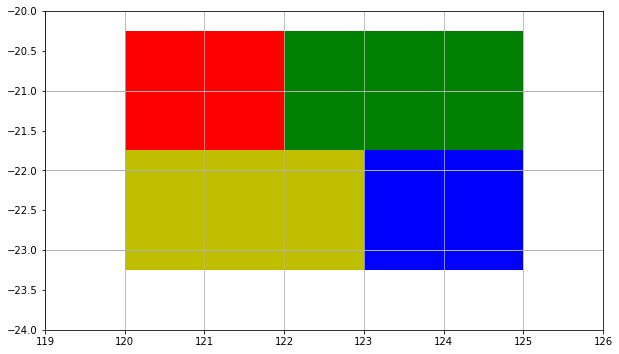

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
shapes.plot(ax=ax, color=['r', 'g', 'y', 'b'])
ax.xaxis.grid(True)
ax.axhline(-21, linewidth=1, color='0.7')
ax.axhline(-22, linewidth=1, color='0.7')
ax.axhline(-23, linewidth=1, color='0.7')
plt.xlim(119, 126)
plt.ylim(-24, -20)
plt.show()

In [13]:
data = np.reshape(np.arange(0, 7*4), [4,7])
data

array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25, 26, 27]])

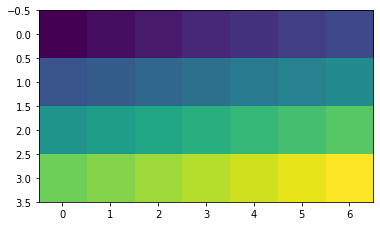

In [14]:
plt.imshow(data)
plt.show()

In [15]:
data.shape

(4, 7)

In [16]:
da = xr.DataArray(
    data,
    dims=("lat", "lon"),
    coords={
        "lat": [-23.5, -22.5, -21.5, -20.5],
        "lon": [119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5]
    }
)


In [30]:
da = da.expand_dims({'ensemble': [0,1,2]})

In [31]:
da

<xarray.DataArray (ensemble: 3, lat: 4, lon: 7)>
array([[[ 0,  1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25, 26, 27]],

       [[ 0,  1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25, 26, 27]],

       [[ 0,  1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25, 26, 27]]])
Coordinates:
  * ensemble  (ensemble) int64 0 1 2
  * lat       (lat) float64 -23.5 -22.5 -21.5 -20.5
  * lon       (lon) float64 119.5 120.5 121.5 122.5 123.5 124.5 125.5

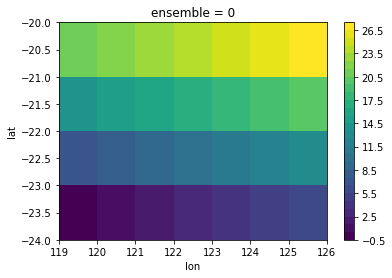

In [32]:
da.isel({'ensemble': 0}).plot(levels=np.arange(-0.5, 28, 1), cmap='viridis')
plt.show()

In [33]:
def fraction_overlap_mask(shapes_gp, lons, lats, min_overlap):
    """Create a 3D boolean array for grid cells over the shape overlap threshold.
    Parameters
    ----------
    shapes_gp : geopandas GeoDataFrame
        Shapes/regions
    lons : numpy ndarray
        Grid longitude values
    lats : numpy ndarray
        Grid latitude values
    threshold : float
        Minimum fractional overlap
    Returns
    -------
    mask_3D : xarray DataArray
        Three dimensional (i.e. region/lat/lon) boolean array
    """

    assert min_overlap > 0.0, "Minimum overlap must be fractional value > 0"
    assert min_overlap <= 1.0, "Minimum overlap must be fractional value <= 1.0"
    _check_regular_grid(lons)
    _check_regular_grid(lats)

    shapes_rm = regionmask.from_geopandas(shapes_gp)
    fraction = overlap_fraction(shapes_rm, lons, lats)
    fraction = _squeeze_and_drop_region(fraction)
    mask_3D = fraction > min_overlap

    return mask_3D


def overlap_fraction(shapes_rm, lons, lats):
    """Calculate the fraction of overlap of regions with lat/lon grid cells.
    Parameters
    ----------
    shapes_rm : regionmask.Regions
        Shapes/regions
    lons : numpy ndarray
        Grid longitude values
    lats : numpy ndarray
        Grid latitude values
    Returns
    -------
    mask_sampled : xarray DataArray
        Three dimensional (i.e. region/lat/lon) array of overlap fractions
    Notes
    -----
    From https://github.com/regionmask/regionmask/issues/38
    Assumes an equally spaced lat/lon grid
    """

    # sample with 10 times higher resolution
    lons_sampled = _sample_coord(lons)
    lats_sampled = _sample_coord(lats)

    mask = shapes_rm.mask(lons_sampled, lats_sampled)
    isnan = np.isnan(mask.values)
    numbers = np.unique(mask.values[~isnan])
    numbers = numbers.astype(np.int)

    mask_sampled = list()
    for num in numbers:
        # coarsen the mask again
        mask_coarse = (mask == num).coarsen(lat=10, lon=10).mean()
        mask_sampled.append(mask_coarse)

    mask_sampled = xr.concat(
        mask_sampled, dim="region", compat="override", coords="minimal"
    )
    mask_sampled = mask_sampled.assign_coords(region=("region", numbers))

    return mask_sampled


def _sample_coord(coord):
    """Sample coordinates for the fractional overlap calculation."""

    d_coord = coord[1] - coord[0]
    n_cells = len(coord)
    left = coord[0] - d_coord / 2 + d_coord / 20
    right = coord[-1] + d_coord / 2 - d_coord / 20

    return np.linspace(left, right, n_cells * 10)


def _squeeze_and_drop_region(ds):
    """Squeeze and drop region dimension if necessary."""

    ds = ds.squeeze()
    try:
        if ds['region'].size <= 1:
            ds = ds.drop('region')
    except KeyError:
        pass

    return ds


def _check_regular_grid(dim_values):
    """Check that a grid (e.g. lat or lon) has uniform spacing."""

    spaces = np.diff(dim_values)
    min_spacing = np.max(spaces)
    max_spacing = np.min(spaces)
    assert math.isclose(min_spacing, max_spacing, rel_tol=1e-4), "Grid spacing must be uniform"

In [34]:
lons = da["lon"].values
lats = da["lat"].values

In [35]:
mask = fraction_overlap_mask(shapes, lons, lats, 0.5)

/var/folders/6v/vrpsky6j509dff7250jyg8240000gp/T/ipykernel_50828/1313764197.py:59: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numbers = numbers.astype(np.int)


In [36]:
mask

<xarray.DataArray 'mask' (region: 4, lat: 4, lon: 7)>
array([[[False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False,  True,  True, False, False, False, False],
        [False,  True,  True, False, False, False, False]],

       [[False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False,  True,  True,  True, False],
        [False, False, False,  True,  True,  True, False]],

       [[False, False, False, False, False, False, False],
        [False,  True,  True,  True, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False]],

       [[False, False, False, False, False, False, False],
        [False, False, False, False,  True,  True, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False]]])
Coordinates:
  * lat      (lat) float64 -23.5 -22.5 -21.5 -20.5
  * lon      (lon) float64 119.5 120.5 121.5 122.5 123.5 124.5 125.5
  * region   (region) int64 0 1 2 3

In [37]:
da_masked = da.where(mask)
da_masked

<xarray.DataArray (ensemble: 3, lat: 4, lon: 7, region: 4)>
array([[[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan,  8., nan],
         [nan, nan,  9., nan],
         [nan, nan, 10., nan],
         [nan, nan, nan, 11.],
         [nan, nan, nan, 12.],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [15., nan, nan, nan],
         [16., nan, nan, nan],
         [nan, 17., nan, nan],
...
         [nan, nan, 10., nan],
         [nan, nan, nan, 11.],
         [nan, nan, nan, 12.],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [15., nan, nan, nan],
         [16., nan, nan, nan],
         [nan, 17., nan, nan],
         [nan, 18., nan, nan],
         [nan, 19., nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [22., nan, nan, nan],
         [23., nan, nan, nan],
         [nan, 24., nan, nan],
         [nan, 25., nan, nan],
         [nan, 26., nan, nan],
         [nan, nan, nan, nan]]]])
Coordinates:
  * ensemble  (ensemble) int64 0 1 2
  * lat       (lat) float64 -23.5 -22.5 -21.5 -20.5
  * lon       (lon) float64 119.5 120.5 121.5 122.5 123.5 124.5 125.5
  * region    (region) int64 0 1 2 3

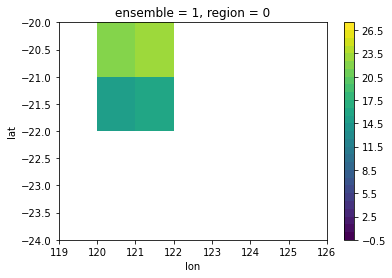

In [38]:
da_masked.isel({'region': 0, 'ensemble': 1}).plot(levels=np.arange(-0.5, 28, 1), cmap='viridis')
plt.show()

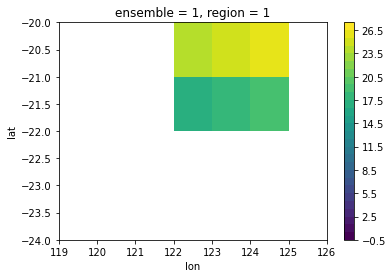

In [39]:
da_masked.isel({'region': 1, 'ensemble': 1}).plot(levels=np.arange(-0.5, 28, 1), cmap='viridis')
plt.show()

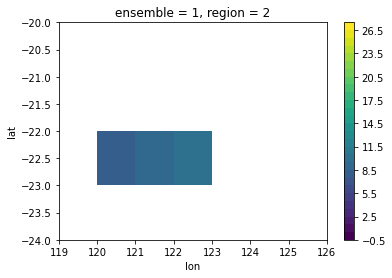

In [40]:
da_masked.isel({'region': 2, 'ensemble': 1}).plot(levels=np.arange(-0.5, 28, 1), cmap='viridis')
plt.show()

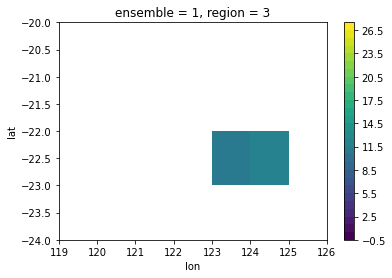

In [41]:
da_masked.isel({'region': 3, 'ensemble': 1}).plot(levels=np.arange(-0.5, 28, 1), cmap='viridis')
plt.show()

In [42]:
da_masked.isel({'region': 3, 'ensemble': 1}).values

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, 11., 12., nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])